In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import os
import glob
import itertools as it
import scipy.stats

In [3]:
rt_data = pd.read_csv("../metfrag/mol_rt_info/all_rt_data.csv").sort_values(by="dataset")
rt_data.groupby("dataset").count()

,pubchem_id,smiles_iso,inchikey,rt,inchikey1,superclass,class,subclass
dataset,,,,,,,,
AU_000,133,133,133,133,133,133,133,133
BML_000,139,139,139,139,139,139,139,139
BS_000,269,269,269,269,269,269,269,269
EA_000,127,127,127,127,127,127,127,127
EA_001,133,133,133,133,133,133,133,133
EQ_000,73,73,73,73,73,73,73,73
EQ_001,78,78,78,78,78,78,78,78
LQB_000,127,127,127,127,127,127,127,127
LU_000,470,470,470,470,470,470,470,470


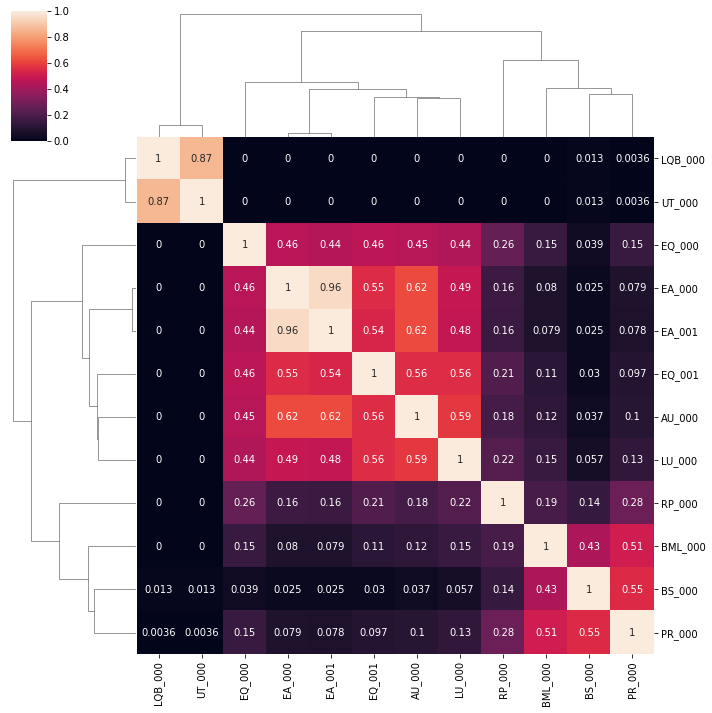

In [4]:
from utils import minmax_kernel_from_dict_lists, get_classyfire_features

Z, dss, cts = get_classyfire_features(rt_data, level="class")
K_Z = minmax_kernel_from_dict_lists(Z)

sns.clustermap(pd.DataFrame(K_Z, columns=dss, index=dss), annot=True, vmax=1, vmin=0, cbar=True)

In [10]:
from sklearn.model_selection import GridSearchCV, KFold, GroupShuffleSplit, RepeatedKFold
from rosvm.ranksvm.rank_svm_cls import KernelRankSVC
from rosvm.feature_extraction.featurizer_cls import CircularFPFeaturizer


cv = GroupShuffleSplit(test_size=0.25, n_splits=25, random_state=33)
cv_inner_single = RepeatedKFold(n_splits=3, n_repeats=3, random_state=39291)
cv_inner_multi = KFold(n_splits=5, shuffle=True, random_state=999)
param_grid = {"C": [1./8, 1./4, 1./2, 1, 4, 8, 16, 32]}
featurizer = CircularFPFeaturizer(only_freq_subs=True, min_subs_freq=0.05, output_dense_matrix=True, radius=6, use_chirality=True)

In [7]:
from utils import run_baseline

res_baseline = run_baseline(
    rt_data,
    cv=cv,
    estimator=GridSearchCV(KernelRankSVC(kernel="minmax", random_state=283), param_grid=param_grid, cv=cv_inner_single, n_jobs=4),
    featurizer=featurizer)

res_baseline.to_csv("./.res_baseline.csv", index=False)

In [8]:
res_baseline.groupby(["dataset", "setting"]).aggregate({"cindex": lambda _v: "%.2f (+/-%.2f)" % (np.mean(_v), np.std(_v)),
                                                        "ranksvm_C": np.median, "n_fps": np.median})

,,cindex,ranksvm_C,n_fps
dataset,setting,,,
AU_000,baseline,0.78 (+/-0.04),4.0,129
BML_000,baseline,0.81 (+/-0.04),4.0,185
BS_000,baseline,0.91 (+/-0.01),8.0,403
EA_000,baseline,0.81 (+/-0.03),4.0,124
EA_001,baseline,0.81 (+/-0.03),8.0,129
EQ_000,baseline,0.63 (+/-0.07),1.0,129
EQ_001,baseline,0.70 (+/-0.06),4.0,149
LQB_000,baseline,0.90 (+/-0.02),32.0,384
LU_000,baseline,0.81 (+/-0.02),8.0,100


In [11]:
from utils import run_multisys

res_multisys = pd.DataFrame()

for use_classyfire_features, local_fps_features in it.product([False, "superclass", "class", "subclass"], [False, True]):
    print(use_classyfire_features, local_fps_features)
    
    _res_multisys = run_multisys(
        rt_data, cv=cv,
        estimator=GridSearchCV(KernelRankSVC(kernel="precomputed", random_state=35), param_grid=param_grid, cv=cv_inner_multi, n_jobs=4),
        featurizer=featurizer,
        use_classyfire_features=use_classyfire_features, local_fps_features=local_fps_features)
    
    res_multisys = pd.concat((res_multisys, _res_multisys), axis=0)

res_multisys.to_csv("./.res_multisys.csv", index=False)

False False
False True
superclass False
superclass True
class False
class True
subclass False
subclass True


In [19]:
res_multisys[res_multisys.dataset=="LQB_000"].groupby(["dataset", "setting", "use_classyfire_features", "local_fps_features"]) \
    .aggregate({"cindex": lambda _v: "%.2f (+/-%.2f)" % (np.mean(_v), np.std(_v)), "ranksvm_C": np.median, "n_fps": np.median})

cindex  \
dataset setting  use_classyfire_features local_fps_features                   
LQB_000 multisys False                   False               0.87 (+/-0.03)   
                                         True                0.88 (+/-0.03)   
                 class                   False               0.91 (+/-0.03)   
                                         True                0.92 (+/-0.02)   
                 subclass                False               0.92 (+/-0.02)   
                                         True                0.93 (+/-0.02)   
                 superclass              False               0.88 (+/-0.03)   
                                         True                0.88 (+/-0.03)   

                                                             ranksvm_C  n_fps  
dataset setting  use_classyfire_features local_fps_features                    
LQB_000 multisys False                   False                     8.0    304  
                                         True                      8.0   2764  
                 class                   False                    16.0    304  
                                         True                     16.0   2764  
                 subclass                False                    16.0    304  
                                         True                     16.0   2764  
                 superclass              False                     8.0    304  
                                         True                      8.0   2764

In [13]:
from utils import run_leavesysout

res_leavesysout = pd.DataFrame()

for use_classyfire_features, local_fps_features in it.product([False, "superclass", "class", "subclass"], [False, True]):
    print(use_classyfire_features, local_fps_features)
    
    _res_leavesysout = run_leavesysout(
        rt_data, 
        cv=cv,
        estimator=GridSearchCV(KernelRankSVC(kernel="precomputed", random_state=35), param_grid=param_grid, cv=cv_inner_multi, n_jobs=4),
        featurizer=featurizer,
        use_classyfire_features=use_classyfire_features, local_fps_features=local_fps_features)
    
    res_leavesysout = pd.concat((res_leavesysout, _res_leavesysout), axis=0)

res_leavesysout.to_csv("./.res_leavesysout.csv", index=False)

False False
AU_000: n_train=2053, n_test=133
BML_000: n_train=2120, n_test=139
BS_000: n_train=1951, n_test=269
EA_000: n_train=2016, n_test=127
EA_001: n_train=2006, n_test=133
EQ_000: n_train=2247, n_test=73
EQ_001: n_train=2241, n_test=78
LQB_000: n_train=2215, n_test=127
LU_000: n_train=1671, n_test=470
PR_000: n_train=1796, n_test=416
RP_000: n_train=2231, n_test=67
UT_000: n_train=2021, n_test=321
False True
AU_000: n_train=2053, n_test=133
BML_000: n_train=2120, n_test=139
BS_000: n_train=1951, n_test=269
EA_000: n_train=2016, n_test=127
EA_001: n_train=2006, n_test=133
EQ_000: n_train=2247, n_test=73
EQ_001: n_train=2241, n_test=78
LQB_000: n_train=2215, n_test=127
LU_000: n_train=1671, n_test=470
PR_000: n_train=1796, n_test=416
RP_000: n_train=2231, n_test=67
UT_000: n_train=2021, n_test=321
superclass False
AU_000: n_train=2053, n_test=133
BML_000: n_train=2120, n_test=139
BS_000: n_train=1951, n_test=269
EA_000: n_train=2016, n_test=127
EA_001: n_train=2006, n_test=133
EQ_0

In [20]:
res_leavesysout[res_leavesysout.dataset=="LQB_000"].groupby(["dataset", "setting", "use_classyfire_features", "local_fps_features"]) \
    .aggregate({"cindex": lambda _v: "%.2f (+/-%.2f)" % (np.mean(_v), np.std(_v)), "ranksvm_C": np.median, "n_fps": np.median})

cindex  \
dataset setting  use_classyfire_features local_fps_features                   
LQB_000 multisys False                   False               0.79 (+/-0.00)   
                                         True                0.82 (+/-0.00)   
                 class                   False               0.80 (+/-0.00)   
                                         True                0.81 (+/-0.00)   
                 subclass                False               0.80 (+/-0.00)   
                                         True                0.81 (+/-0.00)   
                 superclass              False               0.80 (+/-0.00)   
                                         True                0.83 (+/-0.00)   

                                                             ranksvm_C  n_fps  
dataset setting  use_classyfire_features local_fps_features                    
LQB_000 multisys False                   False                       4    304  
                                         True                        4   2764  
                 class                   False                      16    304  
                                         True                        8   2764  
                 subclass                False                       8    304  
                                         True                       16   2764  
                 superclass              False                       8    304  
                                         True                       16   2764